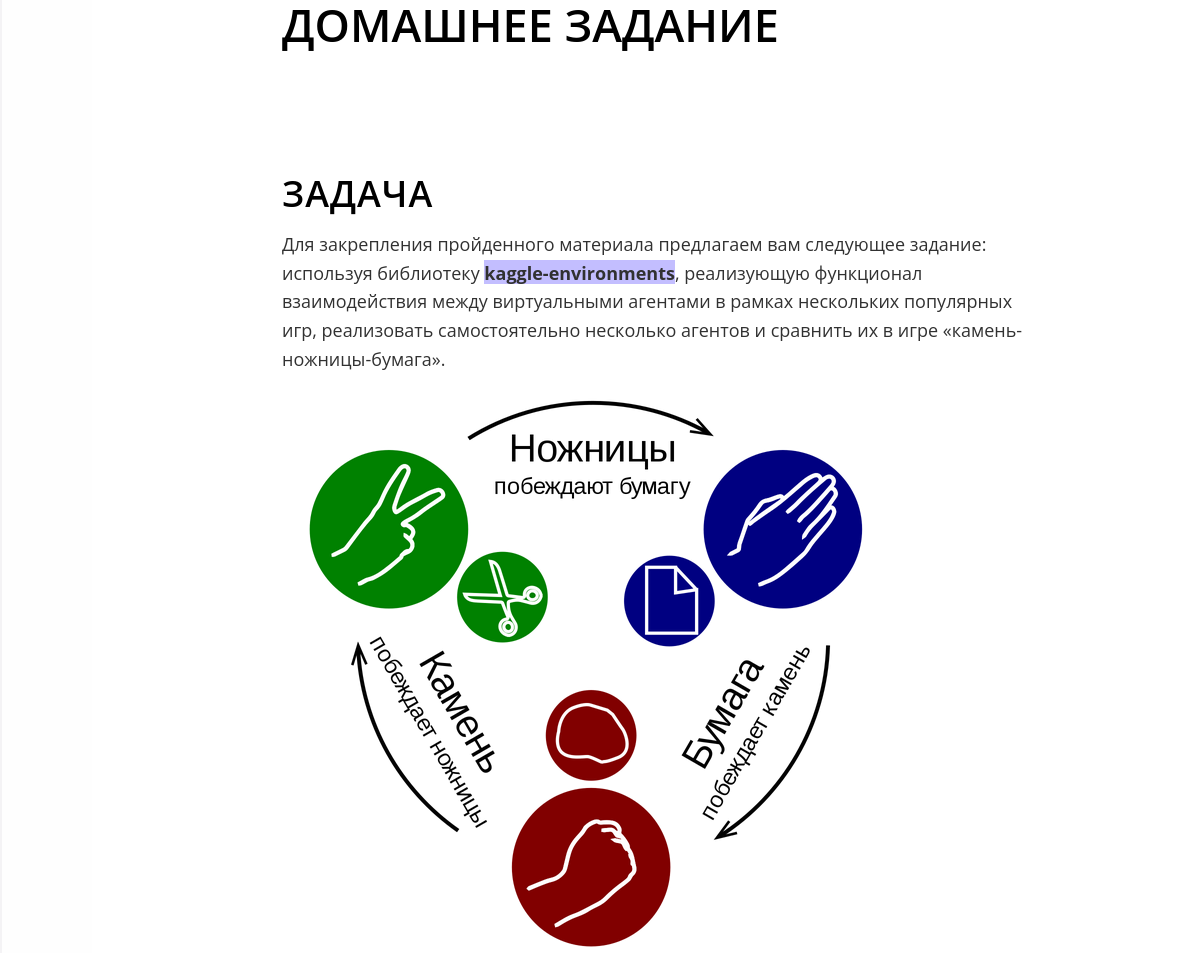
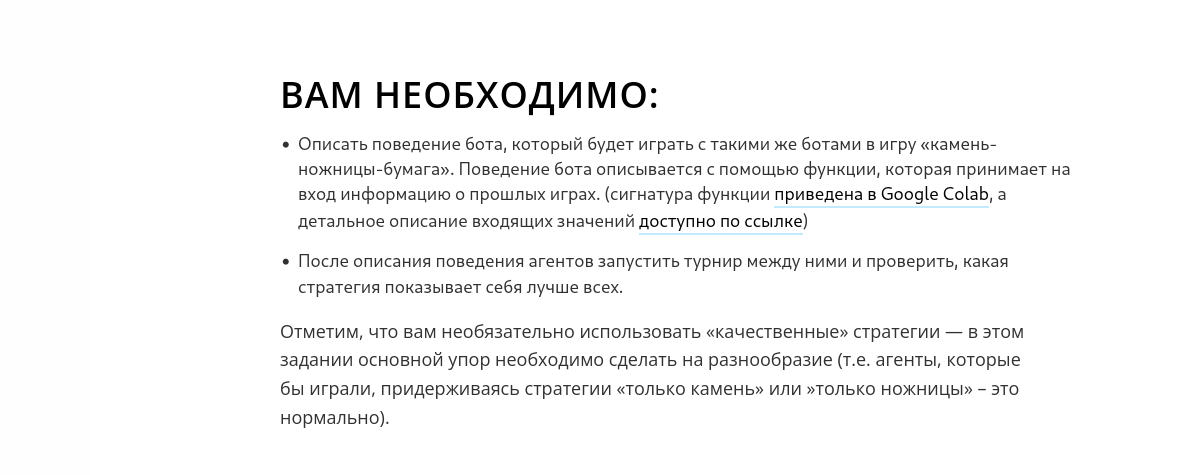
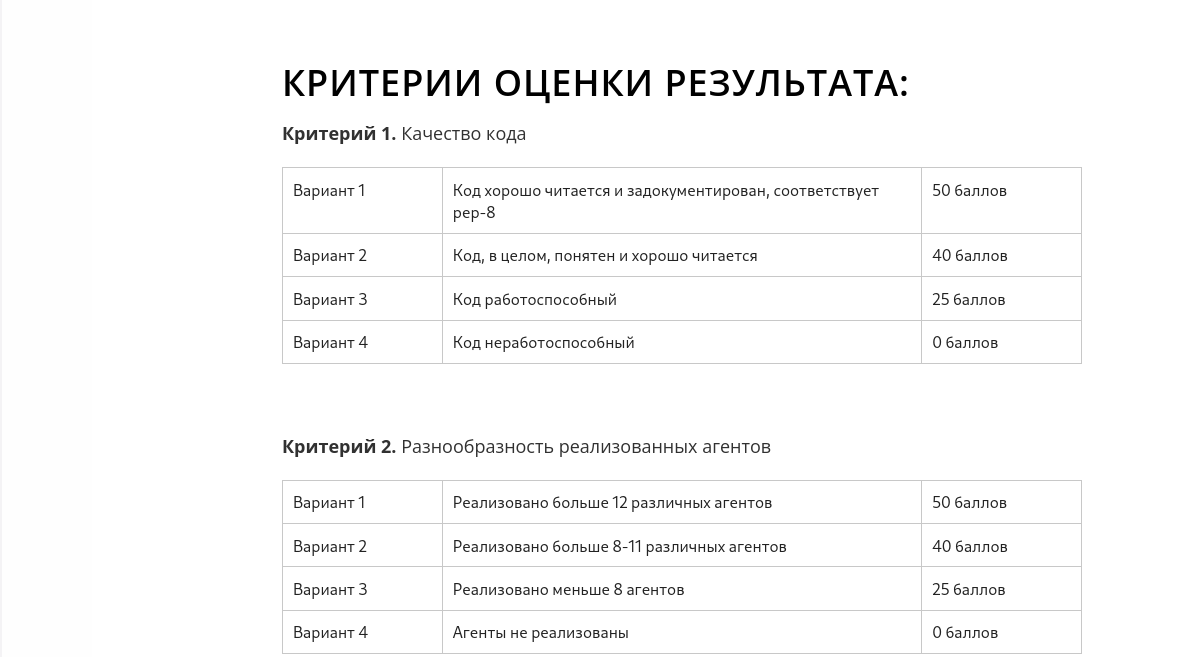

In [25]:
!pip install -q -U kaggle_environments

In [26]:
import numpy as np
import pandas as pd
import random

from kaggle_environments import evaluate

In [27]:
ROCK = 0
PAPER = 1
SCISSORS = 2

In [28]:
def win_action(action: int) -> int:
    return (action + 1) % 3

def rand_rps_action(weights = None) -> int:
    return random.choices([ROCK, PAPER, SCISSORS], weights=weights)[0]

def nearest_action(action: float) -> int:
    return int(round(action)) % 3

In [ ]:
def rock_agent(observation, configuration) -> int:
    """The agent that return ROCK"""
    return ROCK

In [ ]:
def paper_agent(observation, configuration) -> int:
    """The agent that return PAPER"""
    return PAPER

In [ ]:
# Scissors agent
def scissors_agent(observation, configuration) -> int:
    """The agent that return SCISSORS"""
    return SCISSORS

In [ ]:
def copy_opponent(observation, configuration):
    """The agent that copy a previous action"""
    return observation.lastOpponentAction if observation.step > 0 else rand_rps_action()

In [ ]:
def counter_opponent(observation, configuration) -> int:
    """
    The agent that return a winning action to a previous action.
    If step is zero it returns random value
    """
    if observation.step > 0:
        return win_action(observation.lastOpponentAction)
    else:
        return rand_rps_action()


In [ ]:
def circular_opponent(observation, configuration) -> int:
    """Agent returning offset value by 1"""
    return observation.step % 3
    

In [ ]:
def random_agent(observation, configuration):
    """The agent that return a random value"""
    return rand_rps_action()


In [ ]:
def biased_random_agent(observation, configuration):
    """The agent that return a random value by distribution [0.5, 0.25, 0.25]"""
    return rand_rps_action(weights=[0.5, 0.25, 0.25])

In [ ]:
from collections import Counter

opponent_frequency = Counter()

def frequency_based_agent(observation, configuration):
    """The agent return a winning action by the most popular opponent action"""
    global opponent_frequency
    
    if observation.step > 0:
        opponent_frequency.update([observation.lastOpponentAction])
        action, _ = opponent_frequency.most_common(1)[0]
        return win_action(action)
    else:
        return rand_rps_action()

In [ ]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_X_train = []
log_y_train = []

def logistic_regression_agent(observation, configuration):
    """The agent uses the LogisticRegression to predict a winning action"""
    global log_model, log_X_train, log_y_train
    
    if observation.step > 0:
        log_X_train.append([observation.lastOpponentAction])
        log_y_train.append(observation.lastOpponentAction)
        
        if (len(log_y_train) > 10) and len(set(log_y_train)) > 1:
            log_model.fit(log_X_train, log_y_train)
            return win_action(nearest_action(log_model.predict([[observation.lastOpponentAction]])[0]))

    return rand_rps_action()

In [ ]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_X_train = []
lin_y_train = []

def linear_regression_agent(observation, configuration):
    """The agent uses the LinearRegression to predict a winning action"""
    global lin_model, lin_X_train, lin_y_train
    
    if observation.step > 0:
        lin_X_train.append([observation.lastOpponentAction])
        lin_y_train.append(observation.lastOpponentAction)
        
        if (len(lin_y_train) > 10) and len(set(lin_y_train)) > 1:
            lin_model.fit(lin_X_train, lin_y_train)

            return win_action(nearest_action(lin_model.predict([[observation.lastOpponentAction]])[0]))

    return rand_rps_action()

In [ ]:
def adaptive_agent(observation, configuration):
    """
    The agent that return a winning action to a previous action.
    If step % 5 == 0 it returns random value
    """
    if observation.step % 5 == 0:
        return rand_rps_action()
    return win_action(observation.lastOpponentAction)


In [ ]:
import math

def get_score(left_move, right_move):
    """
    Calculates the result of the last action. 
    Returns 0 for a draw, 1 for a win, and -1 for a loss.
    """
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

last_react_action = None
def reactionary_agent(observation, configuration):
    """
    The agent reacts to the latest actions of the enemy.
    If the previous move was lost, chooses a new move.
    """
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)  # случайный первый ход
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs  # выбирает следующий ход

    return last_react_action

In [ ]:
T = np.zeros((3, 3))
P = np.zeros((3, 3))

a1, a2 = None, None

def transition_agent(observation, configuration):
    """
    The agent analyzes the transitions between the enemy's actions and predicts the following.
    """
    global T, P, a1, a2
    if observation.step > 1:
        a1 = observation.lastOpponentAction
        T[a2, a1] += 1  # обновляет матрицу переходов
        P = np.divide(T, np.maximum(1, T.sum(axis=1)).reshape(-1, 1))
        a2 = a1
        if np.sum(P[a1, :]) == 1:
            return int((np.random.choice([0, 1, 2], p=P[a1, :]) + 1) % 3)  # предсказание на основе вероятностей
        else:
            return int(np.random.randint(3))  # случайный ход
    else:
        if observation.step == 1:
            a2 = observation.lastOpponentAction
        return int(np.random.randint(3))

In [ ]:
import itertools

def start_competition(participants: dict, steps: int = 100) -> pd.DataFrame:
    """
    The function breaks into pairs to run the competition
    Returns the table with result of the competition
    """
    
    total_table = pd.DataFrame(index=participants.keys(), columns=participants.keys(), dtype=float)
    
    pairs = list(itertools.combinations(participants, 2))
    
    for first, second in pairs:
        awards = evaluate("rps",
                          [participants[first], participants[second]],
                          configuration={"episodeSteps": steps}, num_episodes=1)
        
        total_table.at[first, second] = awards[0][1]
        total_table.at[second, first] = awards[0][0]
            
    return total_table


In [46]:
participants = {"RockAgent": rock_agent,
                "PaperAgent": paper_agent,
                "ScissorsAgent": scissors_agent,
                "CopyAgent": copy_opponent,
                "ReactionAgent": reactionary_agent,
                "TransitionAgent": transition_agent,
                "CounterAgent": counter_opponent,
                "CircularAgent": circular_opponent,
                "RandomAgent": random_agent,
                "BiasedAgent": biased_random_agent,
                "FrequencyAgent": frequency_based_agent,
                "LogisticAgent": logistic_regression_agent,
                "LinearAgent": linear_regression_agent,
                "AdaptiveAgent": adaptive_agent}

print(f"ParticipantsCount: {len(participants)}")

table = start_competition(participants=participants)

result = {}

for col in table:
    result.update({col: table[col][table[col] > 0].count()})

sorted_dict = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))

max_points = next(iter(sorted_dict.values()))

winners = []
for key, value in sorted_dict.items():
    if (value < max_points):
        break
    winners.append(key)

print(f"The winner(s) {'are' if len(winners) > 1 else 'is'} {winners} with {max_points} wins")

table


ParticipantsCount: 14
The winner(s) are ['CounterAgent', 'LogisticAgent', 'LinearAgent'] with 5 wins


,RockAgent,PaperAgent,ScissorsAgent,CopyAgent,ReactionAgent,TransitionAgent,CounterAgent,CircularAgent,RandomAgent,BiasedAgent,FrequencyAgent,LogisticAgent,LinearAgent,AdaptiveAgent
RockAgent,NaN,99.0,-99.0,0.0,99.0,0.0,98.0,0.0,0.0,0.0,98.0,98.0,98.0,-72.0
PaperAgent,-99.0,NaN,99.0,0.0,98.0,26.0,99.0,0.0,0.0,-30.0,0.0,99.0,98.0,-76.0
ScissorsAgent,99.0,-99.0,NaN,0.0,97.0,35.0,99.0,0.0,0.0,27.0,-98.0,97.0,98.0,-81.0
CopyAgent,0.0,0.0,0.0,NaN,-99.0,0.0,50.0,99.0,0.0,0.0,0.0,50.0,-99.0,0.0
ReactionAgent,-99.0,-98.0,-97.0,99.0,NaN,0.0,0.0,0.0,0.0,0.0,-81.0,0.0,0.0,0.0
TransitionAgent,0.0,-26.0,-35.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-20.0
CounterAgent,-98.0,-99.0,-99.0,-50.0,0.0,0.0,NaN,0.0,0.0,0.0,-49.0,0.0,0.0,22.0
CircularAgent,0.0,0.0,0.0,-99.0,0.0,0.0,0.0,NaN,0.0,0.0,-33.0,0.0,0.0,77.0
RandomAgent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
BiasedAgent,0.0,30.0,-27.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0


In [ ]:
print(table.to_markdown())

|                 |   RockAgent |   PaperAgent |   ScissorsAgent |   CopyAgent |   ReactionAgent |   TransitionAgent |   CounterAgent |   CircularAgent |   RandomAgent |   BiasedAgent |   FrequencyAgent |   LogisticAgent |   LinearAgent |   AdaptiveAgent |
|:----------------|------------:|-------------:|----------------:|------------:|----------------:|------------------:|---------------:|----------------:|--------------:|--------------:|-----------------:|----------------:|--------------:|----------------:|
| RockAgent       |         nan |           99 |             -99 |           0 |              99 |                 0 |             98 |               0 |             0 |             0 |               98 |              98 |            98 |             -72 |
| PaperAgent      |         -99 |          nan |              99 |           0 |              98 |                26 |             99 |               0 |             0 |           -30 |                0 |              99 |       